In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
import pymc as pm
print(f"Running on PyMC v{pm.__version__}") 
import arviz as az

Running on PyMC v5.8.0


## Ex2. Conjugate gamma-poisson hierarchical model... Pumps

Example 2.

The example relates to **10** power plant pumps. 
The data is given in the following table and gives the number of failures $x_i$ and the length of operation time $t_i$ (in thousands of hours) for each pump.
Pump | $$t_i$$| $$x_i$$|
:----|----:|----:|
1    | 94.50  | 5 |
2    | 15.70  | 1 |
3    | 62.90  | 5 |
4    | 126.00 | 14|
5    |   5.24 | 3 |
6    |  31.40 | 19|
7    | 1.05   | 1 |
8    | 1.05   | 1 |
9    | 2.10   | 4 |
10   | 10.50  | 22|        

**Pumps: conjugate gamma-poisson hierarchical model**

\begin{align*}
      X_i \mid \theta_i &\sim \text{Poisson}(\theta_i t_i) \\
     \theta_i | \alpha, \beta  &\sim \text{Gamma}(\alpha, \beta) \\
     \alpha &\sim \text{Exponential}(1) \\
     \beta &\sim \text{Gamma}(0.1, 1) 
\end{align*}

10 power plant pumps 
- $X_i$: number of failures,  $i=1,...,10$.
- $𝜃_𝑖$: failure rate for pump $i$,  $i=1,...,10$.
- $𝑡_𝑖$: length of operation time of the pump (in 1000s of hours)

In [3]:
t_data = np.array([94.50, 15.70, 62.90, 126.0, 5.24, 31.4, 1.05, 1.05, 2.10, 10.50])
X_data = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22])
group_idx = np.arange(10) #Return: Array of evenly spaced values. 

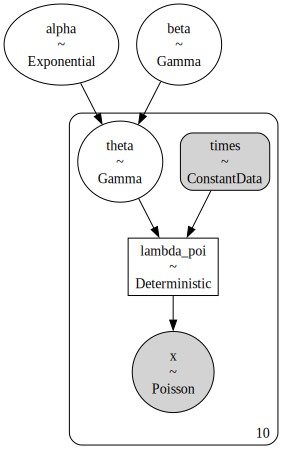

In [4]:
##Creates a new Model object: start_model
with pm.Model() as m_pumps:  #container for the model random variables.
## Define the Prior:
    ## 1. Stochastic random variables, 
    ## pm.distribution("variable_name", distribution's parameter, shape or dimension )
    alpha = pm.Exponential("alpha",lam=1)
    beta = pm.Gamma("beta", alpha=0.1, beta=1)
    theta = pm.Gamma("theta", alpha=alpha, beta=beta, shape=10) 
    
    ## 2. Deterministic random variable, 
    ## pm.Deterministic("variable_name", mathematical operation, shape or dimension)
    times = pm.ConstantData("times", t_data)
    lambda_poi = pm.Deterministic("lambda_poi", theta * times)

## Define the Likelihood:
    ## pm.distribution(.., observed = data).
    x = pm.Poisson("x", mu=lambda_poi[group_idx], observed=X_data)
pm.model_to_graphviz(model=m_pumps)

In [5]:
gv = pm.model_graph.model_to_graphviz(model=m_pumps)
gv.format = 'png'
gv.render(filename='ex_2_pumps_m')

'ex_2_pumps_m.png'

In [4]:
with m_pumps:
    idata_pumps = pm.sample(draws=1000, random_seed=101)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [5]:
az.summary(idata_pumps,var_names=["~lambda_poi"], 
           hdi_prob=0.95,round_to=3,kind='stats') 

,mean,sd,hdi_2.5%,hdi_97.5%
alpha,0.696,0.266,0.228,1.224
beta,0.919,0.531,0.079,1.956
theta[0],0.060,0.025,0.019,0.111
theta[1],0.102,0.080,0.000,0.251
theta[2],0.090,0.038,0.025,0.163
theta[3],0.116,0.030,0.058,0.174
theta[4],0.602,0.317,0.098,1.239
theta[5],0.610,0.136,0.362,0.879
theta[6],0.902,0.740,0.007,2.292
theta[7],0.883,0.700,0.002,2.206


<font color=#dc143c>[*說明*]</font>有些theta(failure rate)比較高，值得注意一下~

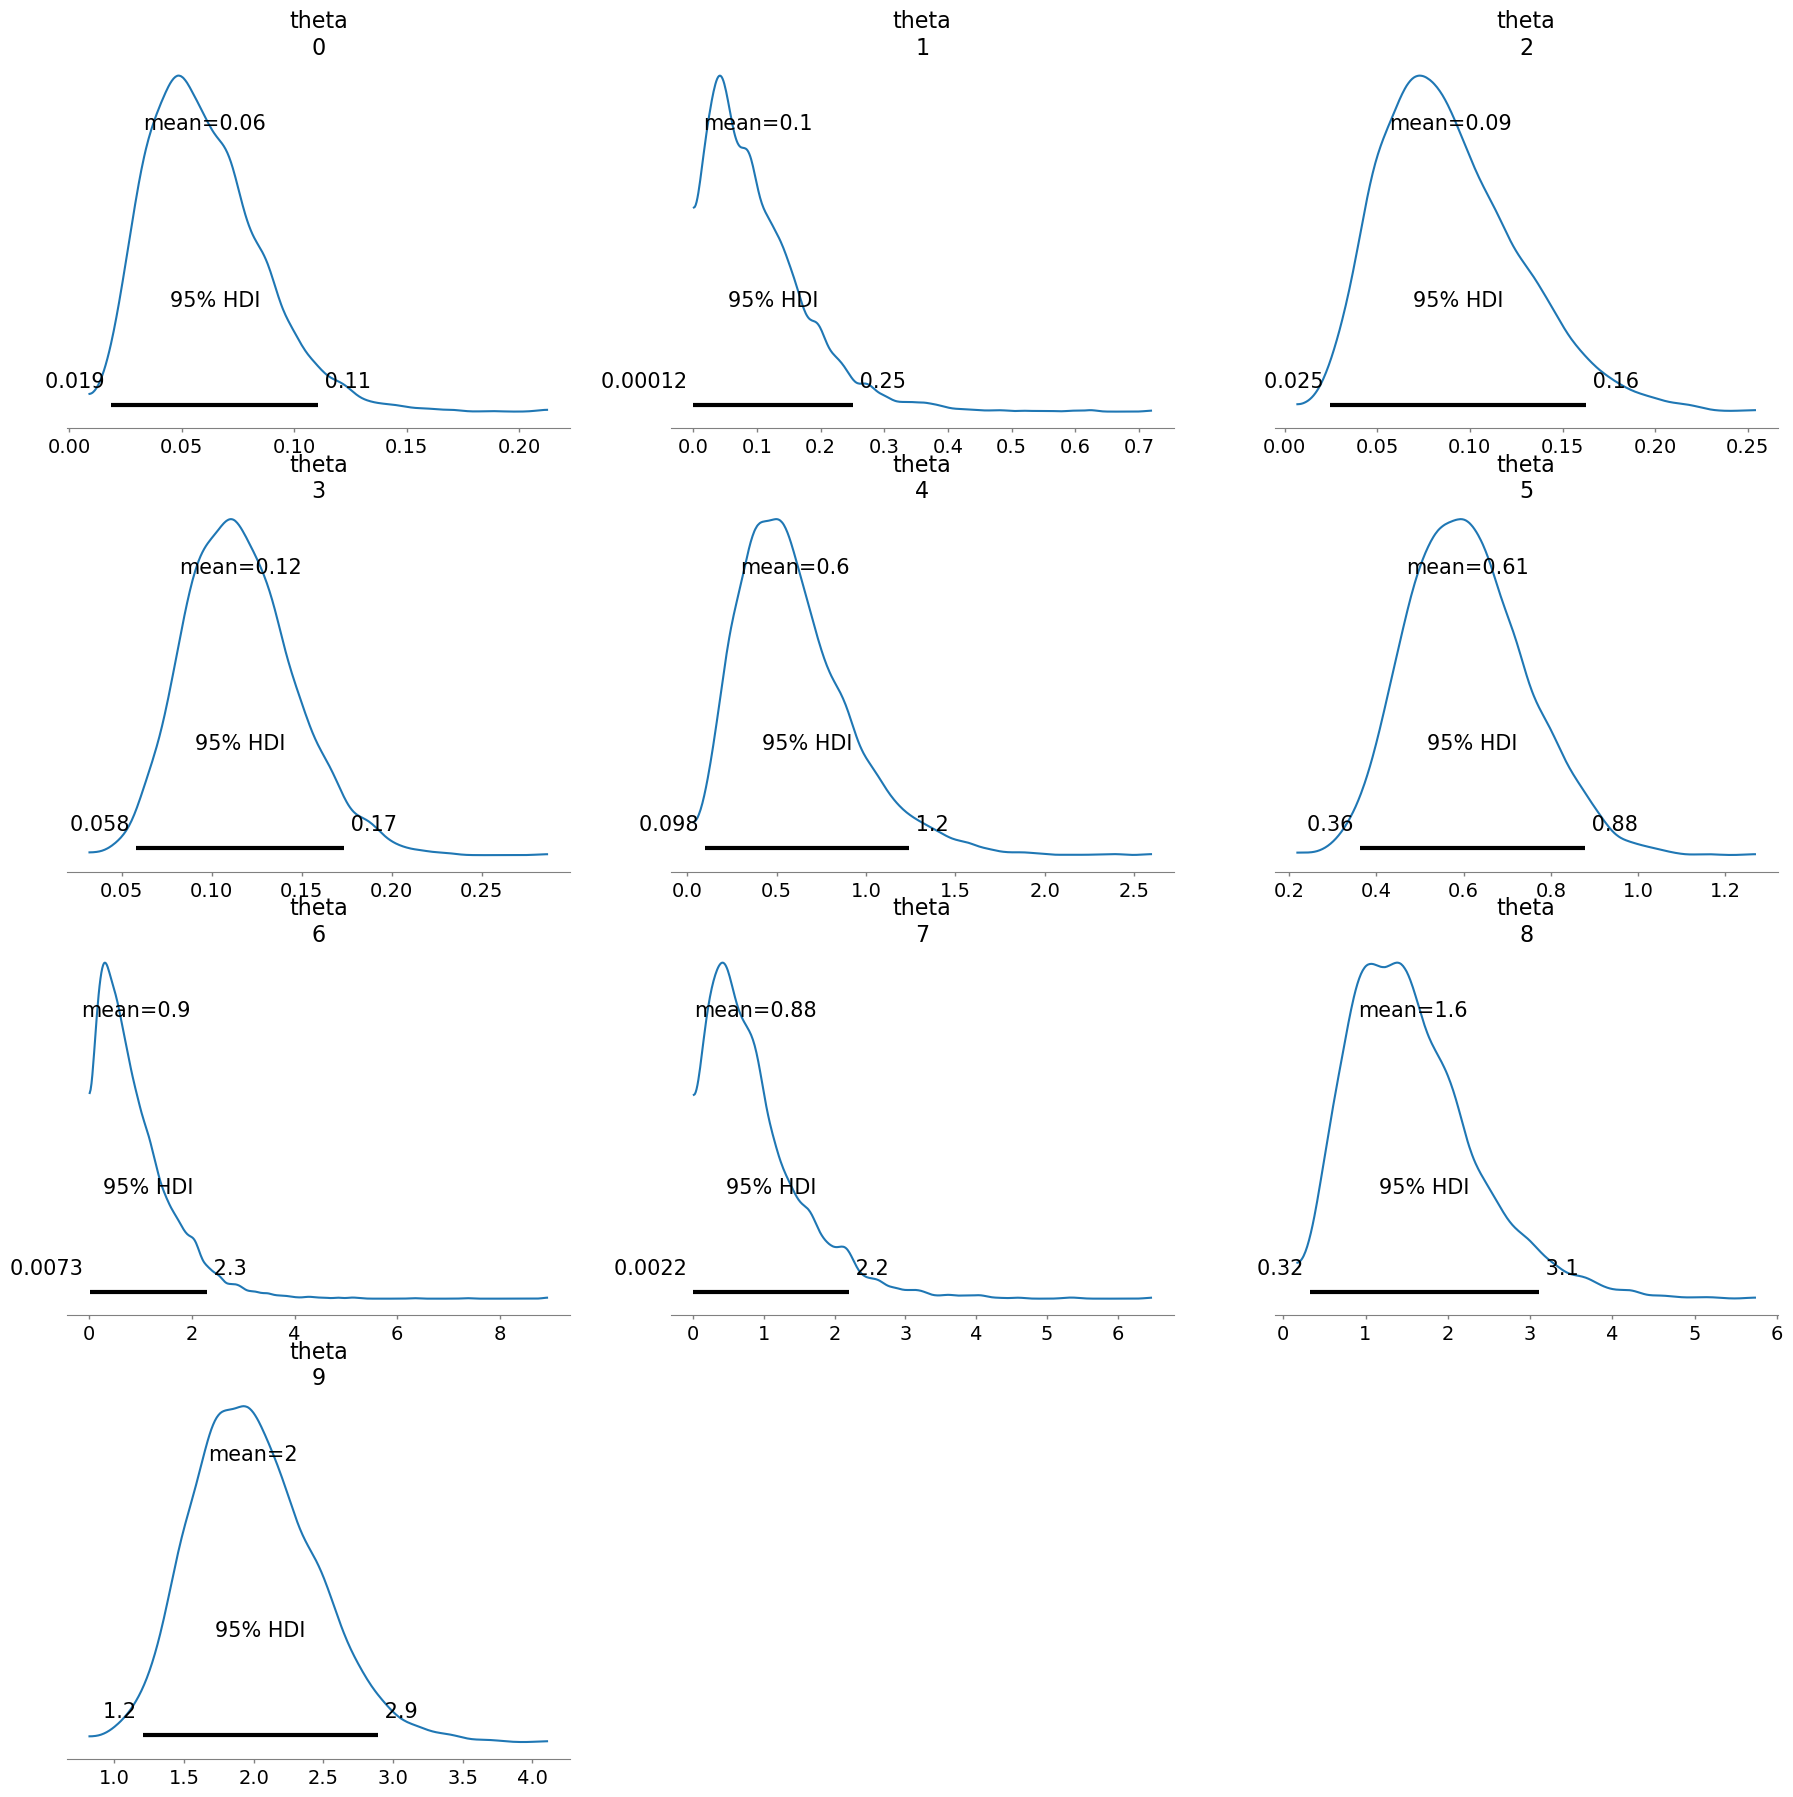

In [6]:
az.plot_posterior(idata_pumps, var_names=["theta"],hdi_prob=0.95)
plt.show()

### Reference:

MultiBUGS Example: https://www.multibugs.org/examples/latest/Pumps.html

R + JAGS Example: https://rpubs.com/Maha_Abouamouna/1044799